## Clustering users based on their topic distributions

In [1]:
from google.colab import drive
drive.mount("/content/drive")
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('/content/drive/MyDrive/')
from dataclasses import dataclass
import matplotlib.pyplot as plt
import pandas as pd
from typing import List, Dict, Optional, Tuple, Union
import random
import numpy as np
import re
import ast

Mounted at /content/drive


In [2]:
ratings_df = pd.read_csv("/content/drive/MyDrive/Regenesys/ratings.csv")
captions_df = pd.read_csv("/content/drive/MyDrive/Regenesys/evaluation/evaluate_using_caption/captions_gpt4omini_realimg.csv")
topics_df = pd.read_csv("/content/drive/MyDrive/Regenesys/evaluation/evaluate_using_caption/topics.csv")
doc_topic_df = pd.read_csv("/content/drive/MyDrive/Regenesys/evaluation/evaluate_using_caption/doc_topic_df.csv")
num_topics = topics_df.shape[0]

ratings_df.drop(columns=["Unnamed: 0", "worker"], inplace=True)
liked_df = ratings_df[ratings_df["score"]>=4]
captions_df.drop(columns=["Unnamed: 0"], inplace=True)

liked_counts = (
    ratings_df[ratings_df['score'] >= 4]
    .groupby('worker_id')['score']
    .count()
    .reset_index(name='liked_count')
)
valid_users_id = liked_counts[liked_counts['liked_count'] >= 20]['worker_id'].unique()
print(f"Number of valid users: {len(valid_users_id)}")
filtered_ratings_df = ratings_df[ratings_df['worker_id'].isin(valid_users_id)].copy()
worker_mapping = {old_id: new_id for new_id, old_id in enumerate(valid_users_id)}
filtered_ratings_df.rename(columns={'worker_id': 'old_worker_id'}, inplace=True)
filtered_ratings_df['worker_id'] = filtered_ratings_df['old_worker_id'].map(worker_mapping)

liked_df = filtered_ratings_df[filtered_ratings_df["score"]>=4]
liked_df = liked_df.merge(captions_df, left_on="imagePair", right_on="Image", how="inner").drop(columns=["imagePair"])
liked_df.head(2)

Number of valid users: 188


,score,old_worker_id,image_id,worker_id,Image,Caption
0,4,0,1,0,farm1_106_268532564_c273eb23e6.jpg,Drummers performing a lively traditional taiko...
1,4,0,2,0,farm8_7224_7246491674_540646a594.jpg,Nature's colorful duo: a peacock and an emu on...


In [3]:
liked_df_topics = liked_df.merge(
    doc_topic_df[["caption", "picked_topics", "picked_probs"]],
    left_on="Caption",
    right_on="caption",
    how="left"
).drop(columns=["Caption"])

def safe_eval(x):
    try:
        return ast.literal_eval(x)
    except (ValueError, SyntaxError):
        return []

liked_df_topics['picked_topics'] = liked_df_topics['picked_topics'].apply(safe_eval)
liked_df_topics['picked_probs'] = liked_df_topics['picked_probs'].apply(safe_eval)


# Compute topic distributions over users
user_ids = liked_df_topics["worker_id"].unique()
user_topic_sums = {u: np.zeros(num_topics) for u in user_ids}

for row in liked_df_topics.itertuples(index=False):
    worker_id = getattr(row, "worker_id")
    for t_id, t_prob in zip(row.picked_topics, row.picked_probs):
        user_topic_sums[worker_id][t_id] += t_prob

for user_id in user_ids:
    user_topic_sums[user_id] = user_topic_sums[user_id] / user_topic_sums[user_id].sum()

In [7]:
user_topic_distribution_df = pd.DataFrame.from_dict(user_topic_sums, orient='index')
user_topic_distribution_df.reset_index(inplace=True)
user_topic_distribution_df.rename(columns={'index': 'worker_id'}, inplace=True)
user_topic_distribution_df.head(2)

,worker_id,0,1,2,3,4,5,6,7,8,...,171,172,173,174,175,176,177,178,179,180
0,0,0.005182,0.0,0.005038,0.001727,0.011517,0.006238,0.005182,0.001209,0.005182,...,0.001171,0.004297,0.008756,0.00000,0.000000,0.014437,0.010851,0.026741,0.016408,0.013257
1,1,0.000000,0.0,0.000000,0.000000,0.000000,0.054046,0.000000,0.000000,0.000000,...,0.000000,0.019588,0.000000,0.00998,0.035987,0.000000,0.001372,0.006806,0.035280,0.010194


## User Visualization

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler


features = user_topic_distribution_df.drop(columns=['worker_id'])
# scaler = StandardScaler()
# features_scaled = scaler.fit_transform(features)

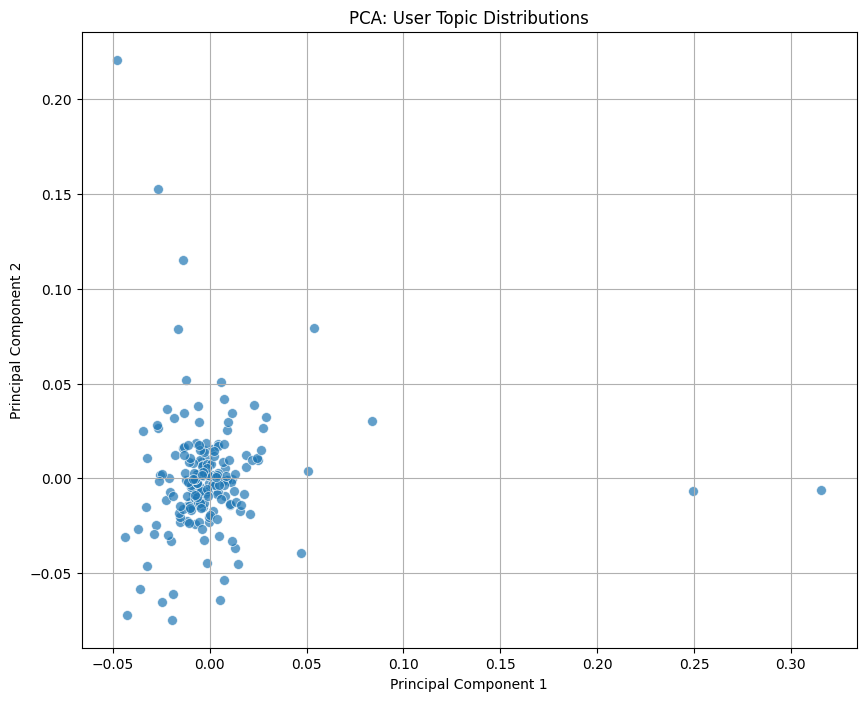

In [14]:
# PCA
pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(features)
pca_df = pd.DataFrame({
    'worker_id': user_topic_distribution_df['worker_id'],
    'PC1': pca_result[:, 0],
    'PC2': pca_result[:, 1]
})
plt.figure(figsize=(10, 8))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', s=50, alpha=0.7)
plt.title('PCA: User Topic Distributions')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 188 samples in 0.001s...
[t-SNE] Computed neighbors for 188 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 188 / 188
[t-SNE] Mean sigma: 0.036284
[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.606087
[t-SNE] KL divergence after 1000 iterations: 0.910594


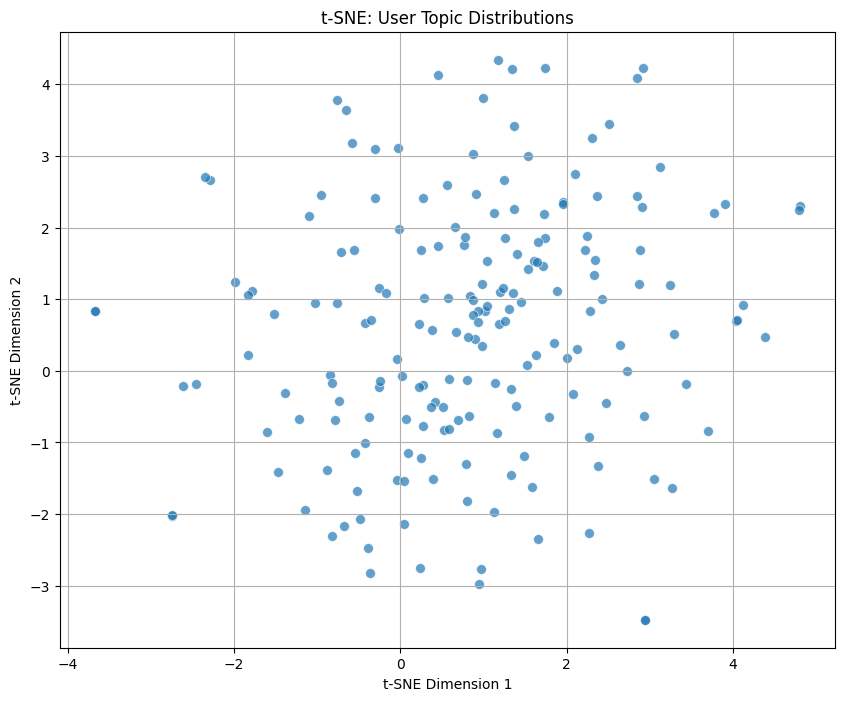

In [15]:
# t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42, verbose=1)
tsne_result = tsne.fit_transform(features)

tsne_df = pd.DataFrame({
    'worker_id': user_topic_distribution_df['worker_id'],
    'TSNE1': tsne_result[:, 0],
    'TSNE2': tsne_result[:, 1]
})
plt.figure(figsize=(10, 8))
sns.scatterplot(data=tsne_df, x='TSNE1', y='TSNE2', s=50, alpha=0.7)
plt.title('t-SNE: User Topic Distributions')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.grid(True)
plt.show()

# User clustering

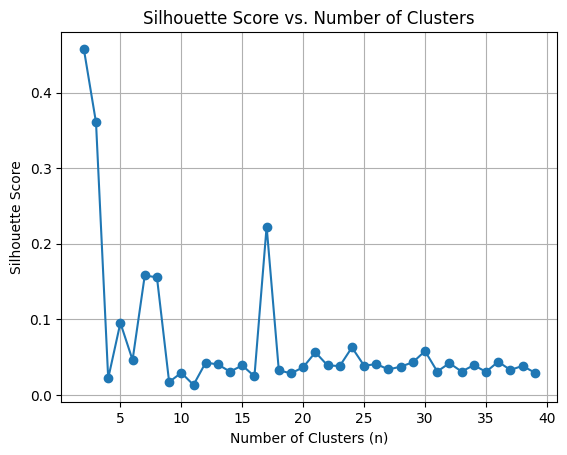

In [26]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

s_scores = []
for n_clusters in range(2, 40):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=100)
    kmeans_labels = kmeans.fit_predict(features)
    # Calculate Silhouette Score
    kmeans_silhouette = silhouette_score(features, kmeans_labels)
    s_scores.append(kmeans_silhouette)
    # print(f"n={n_clusters}, S Score: {kmeans_silhouette:.4f}")

plt.plot(range(2, 40), s_scores, marker='o')
plt.xlabel('Number of Clusters (n)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.grid(True)

In [38]:
user_cluster_df = liked_df[['old_worker_id', 'worker_id']].drop_duplicates().reset_index(drop=True).sort_values(by='worker_id')
for n_clusters in [2, 3, 5, 7, 17, 18, 37]:
    # 2,3,5,7,17 have high S score; 18 = 188//10; 37 = 188//5
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=100)
    kmeans_labels = kmeans.fit_predict(features)
    user_cluster_df[f'cluster_{n_clusters}'] = kmeans_labels

In [40]:
user_cluster_df.to_csv("/content/drive/MyDrive/Regenesys/evaluation/evaluate_using_caption/user_cluster_df.csv", index=False)